In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
def euclid(df):
    return np.sqrt((df['centroid_x'] - df['centroid_x'].shift(1))**2 + 
                   (df['centroid_y'] - df['centroid_y'].shift(1))**2
)

In [2]:
pth = Path(r'/home/oldboy/Documents/GitHub/thermal tognini/thermal_data')
#pth = Path(r'D:\thermography\cdkl5_thermal_behaviour_group1\unico')
content = os.listdir(pth)
content = list(filter(lambda x: (pth/x).is_dir(), content ) ) 

subjects = dict()
for c in content:
    parts = c.split('-')
    sub_id = parts[2]
    if sub_id not in subjects.keys():
        subjects[sub_id] = dict()
        subjects[sub_id]['id'] = parts[2] 
        subject_parts = subjects[sub_id]['id'].split('_')
        subjects[sub_id]['geno'] = subject_parts[0]
        subjects[sub_id]['number'] = subject_parts[1]
        subjects[sub_id]['recordings'] = [(pth/c/'data.csv').as_posix()]
    else:
        subjects[sub_id]['recordings'].append( (pth/c/'data.csv').as_posix() )

subjects = pd.DataFrame.from_dict(subjects).T.reset_index(drop=True)
subjects['recordings'] = subjects['recordings'].apply(sorted)

In [3]:

for i,row in subjects.iterrows():
    if i==5:
        break

data = list()
for i,rec in enumerate(row['recordings']):
    df = dd.read_csv(rec,sep=';', skiprows=1,dtype={'isDay': 'float64'}, parse_dates=['Date'])
    df['temp_med_delta'] = (df['temp_med']-df['temp_med'].mean())
    df['distance'] = euclid(df)
    df['RT_delta'] = df['RT']-df['RT'].mean()
    data.append(df)

data = dd.concat(data)
data['start_date'] = data['Date'].min()
data['day'] = (data['Date'] - data['start_date']).dt.days + 1

min_data = data.groupby(['minute','day']).mean().compute()
min_data['temp_rt_delta'] = min_data['temp_avg']-min_data['RT']
min_data['temp_rt_delta'] = min_data['temp_rt_delta'] - min_data['temp_rt_delta'].mean()
min_data['temp_norm'] = min_data['temp_avg']-min_data['temp_avg'].mean()
min_data['RT_norm'] = min_data['RT']-min_data['RT'].mean()
min_data['temp_rt_correct'] = min_data['temp_norm']-min_data['RT_norm']


day_data = data.groupby(['minute']).mean().compute()
day_data['temp_rt_delta'] = day_data['temp_avg']-day_data['RT']
day_data['temp_rt_delta'] = day_data['temp_rt_delta'] - day_data['temp_rt_delta'].mean()
day_data['temp_norm'] = day_data['temp_avg']-day_data['temp_avg'].mean()
day_data['RT_norm'] = day_data['RT']-day_data['RT'].mean()
day_data['temp_rt_correct'] = day_data['temp_norm']-day_data['RT_norm']




<IPython.core.display.Javascript object>


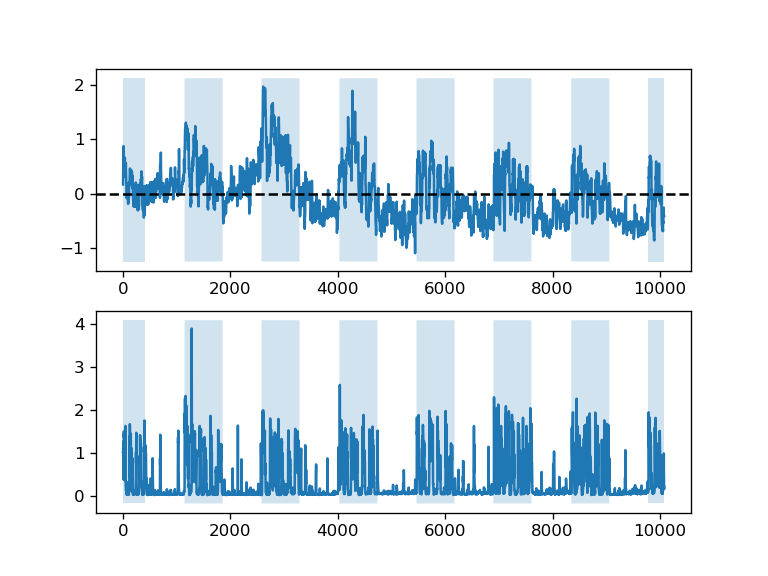

In [4]:
%matplotlib notebook
fig,ax = plt.subplots(2,1)

temperature = min_data['temp_rt_delta'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[0].plot(temperature)
ax[0].axhline(0,color='k',linestyle='--')
lims = ax[0].get_ylim()
ax[0].fill_between(temperature.index, lims[0], lims[1],where= min_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)

motion = min_data['distance'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[1].plot(motion)
lims = ax[1].get_ylim()
ax[1].fill_between(temperature.index, lims[0], lims[1],where= min_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)


<IPython.core.display.Javascript object>


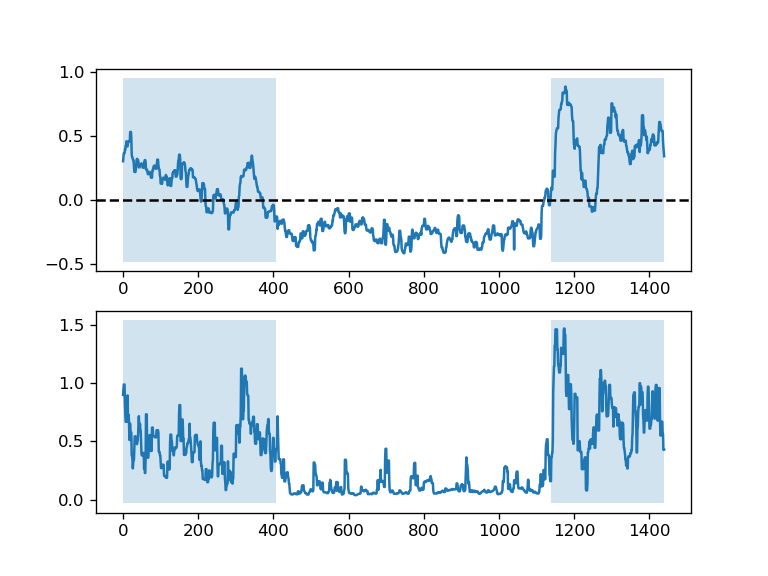

In [5]:
fig,ax = plt.subplots(2,1)

day_temperature = day_data['temp_rt_delta'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[0].plot(day_temperature)
ax[0].axhline(0,color='k',linestyle='--')
lims = ax[0].get_ylim()
ax[0].fill_between(day_temperature.index, lims[0], lims[1],where= day_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)

day_motion = day_data['distance'].reset_index(drop=True).rolling(5,min_periods=1,center=True).median()
ax[1].plot(day_motion)
lims = ax[1].get_ylim()
ax[1].fill_between(day_temperature.index, lims[0], lims[1],where= day_data['isDay'].reset_index(drop=True)<.00001,alpha=.2)


<IPython.core.display.Javascript object>


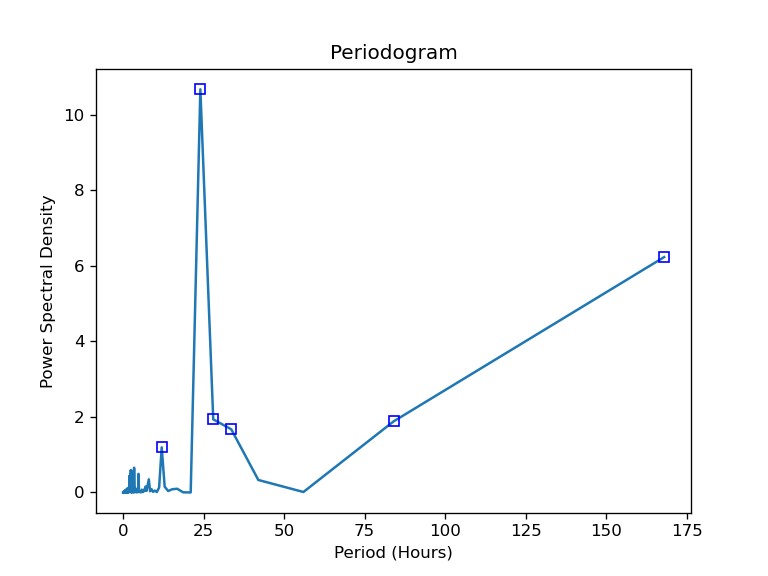

Text(0.5, 1.0, 'Periodogram')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
from statsmodels.stats.multitest import fdrcorrection


fs = 60
x = temperature

def periodogram(x,fs=60):
    frequencies, power_spectrum = signal.periodogram(x, fs)
    frequencies = frequencies
    power_spectrum =  np.insert(np.flip(power_spectrum[1:]),0,power_spectrum[0])
    period =  np.insert(np.flip(1 / frequencies[1:]),0,0)

    p_values = 1 - power_spectrum  # Convert power values to p-values
    rejected, _ = fdrcorrection(p_values)

    peaks = period[rejected]
    amplitudes = power_spectrum[rejected]
    peaks_signi = pd.DataFrame({'period': peaks, 'amplitude': amplitudes})
    return power_spectrum, period, peaks_signi
    

power_spectrum, period, peaks_signi = periodogram(x,fs=60)
plt.figure()
plt.plot(period, power_spectrum)

for i,row in peaks_signi.iterrows():
    plt.plot(row['period'], row['amplitude'], 'sb',markerfacecolor='None')

plt.xlabel('Period (Hours)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')

Component 1:
Mesor: 9.98
Amplitude: 4.94
Period: 24.18
Acrophase: 6.00

Component 2:
Amplitude: 2.87
Period: 11.81
Acrophase: 1.14

Component 3:
Amplitude: 2.00
Period: 2.00
Acrophase: 0.00


<IPython.core.display.Javascript object>


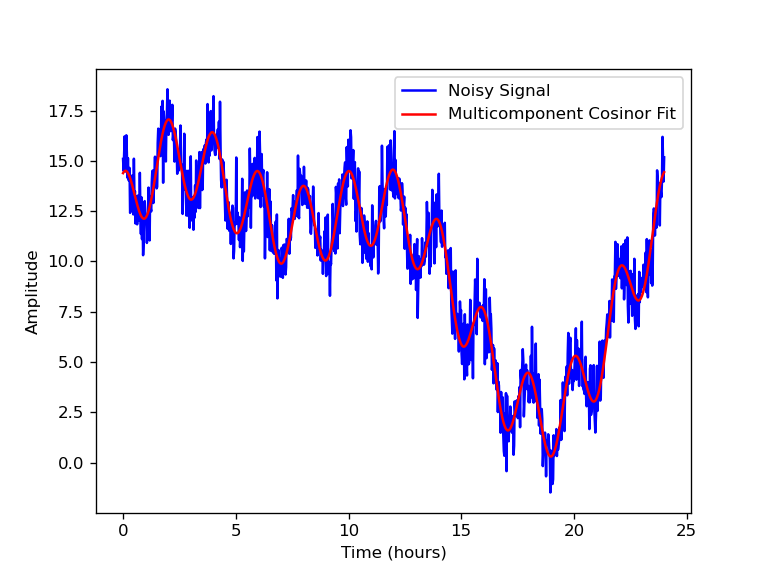

In [110]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the time points
time_points = np.linspace(0, 24, 1000)

mesor = 10
amplitude1 = 5
period1 = 24 
acrophase1 = 6

# Define the parameters for the second component
amplitude2 = 3
period2 = 12  # 12-hour period
acrophase2 = 1 # Acrophase of 18 hours

# Define the parameters for the second component
amplitude3 = 2
period3 = 2  # 12-hour period
acrophase3 = 4 # Acrophase of 18 hours

# Generate the first component
component1 = amplitude1 * np.cos((2 * np.pi * (time_points - acrophase1)) / period1)
component2 = amplitude2 * np.cos((2 * np.pi * (time_points - acrophase2)) / period2)
component3 = amplitude3 * np.cos((2 * np.pi * (time_points - acrophase3)) / period3)

# Combine the components to create the synthetic signal
signal = component1 + component2 + component3

# Add some random noise to the signal
np.random.seed(42)  # Set a seed for reproducibility
noise_amplitude = 1
noise = np.random.normal(0, noise_amplitude, len(signal))
noisy_signal = mesor + signal + noise

# Define the multicomponent cosine function
#def multicomponent_cosinor(x, mesor1, ampl1, period1, acrophase1, ampl2, period2, acrophase2):
#    return mesor1 + (ampl1 * np.cos((2 * np.pi * (x - acrophase1)) / period1) ) + ( ampl2 * np.cos((2 * np.pi * (x - acrophase2)) / period2) )

def multicomponent_cosinor(x, mesor, *args):
    num_components = len(args) // 3
    result = np.full_like(x, mesor)

    for i in range(num_components):
        amplitude = args[3 * i]
        period = args[3 * i + 1]
        acrophase = args[3 * i + 2]
        result += amplitude * np.cos((2 * np.pi * (x - acrophase)) / period)

    return result

# Perform curve fitting
p0 = [np.mean(noisy_signal), 
      np.max(noisy_signal) - np.min(noisy_signal), 24, 0,
      np.max(noisy_signal) - np.min(noisy_signal), 12, 0 ,
     np.max(noisy_signal) - np.min(noisy_signal), 2, 0 ]  

bounds = [ [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf,np.inf, np.inf, np.inf ] ]
params, _ = curve_fit(multicomponent_cosinor, time_points, noisy_signal, p0=p0, bounds=bounds)

# Extract the mesor, amplitude, period, and acrophase values for each component
mesor1 = params[0]
ampl1 = params[1]
period1 = params[2]
acrophase1 = params[3] % 24  # Correct the acrophase to be within 0-24 range
ampl2 = params[4]
period2 = params[5]
acrophase2 = params[6] % 24  # Correct the acrophase to be within 0-24 range
ampl3 = params[7]
period3 = params[8]
acrophase3 = params[9] % 24  # Correct the acrophase to be within 0-24 range

# Print the results
print("Component 1:")
print("Mesor: {:.2f}".format(mesor1))
print("Amplitude: {:.2f}".format(ampl1))
print("Period: {:.2f}".format(period1))
print("Acrophase: {:.2f}".format(acrophase1))
print()
print("Component 2:")
print("Amplitude: {:.2f}".format(ampl2))
print("Period: {:.2f}".format(period2))
print("Acrophase: {:.2f}".format(acrophase2))
print()
print("Component 3:")
print("Amplitude: {:.2f}".format(ampl3))
print("Period: {:.2f}".format(period3))
print("Acrophase: {:.2f}".format(acrophase3))

plt.figure()
# Plot the noisy signal and fitted curve
plt.plot(time_points, noisy_signal, 'b-', label='Noisy Signal')
plt.plot(time_points, multicomponent_cosinor(time_points, *params), 'r-', label='Multicomponent Cosinor Fit')
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



In [96]:
initial_params

NameError: name 'initial_params' is not defined